In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [468]:
from tslearn.datasets import CachedDatasets 

X_train, Y_train, X_test, Y_test = CachedDatasets().load_dataset("Trace")

# Preprocessing for Time Series Clustering


Before clustering, I applied Min-Max normalization to scale the time series between 0 and 1, ensuring that all values had a consistent range and preventing large variations from dominating the clustering process.

To further stabilize variance and reduce the impact of outliers, I applied a logarithmic transformation twice. The first log transformation compressed large values, while the second log further enhanced the differentiation of small variations in the data. This step helped to make the patterns in the time series more distinguishable, improving clustering performance.

In [469]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

scaler = TimeSeriesScalerMinMax(value_range=(4.0, 5.0))

# Normalize each time series individually
X_norm = scaler.fit_transform(X_train)

X_log = np.log(np.log(X_norm))

# Vizualisation with actual labels

Let's randomly select time series from the original dataset and visualize them to compare their patterns before preprocessing.

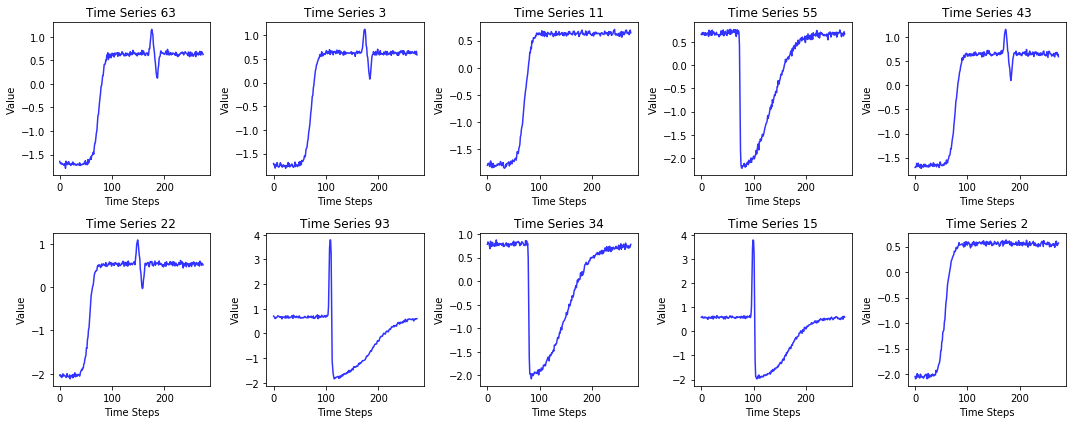

In [145]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
axes = axes.flatten()  

for i in range(10):
    ax = axes[i]
    
    index = np.random.choice(X_train.shape[0], 1)[0]
    series = X_train[index]
    
    ax.plot(series, color='b', alpha=0.8)
    ax.set_title(f"Time Series {index}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()

I observe that some time series exhibit similar patterns, such as (63,3,43,22) or (34,55) or (11,2). In particular, time series 3 and 11 are highly similar, differing only in a small range, making them more prone to misclustering.

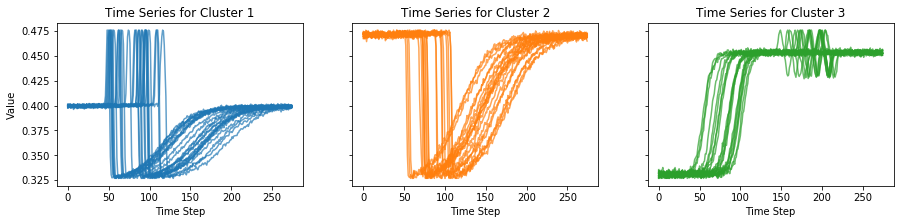

In [470]:
n_clusters = 3
fig, axes = plt.subplots(1, n_clusters, figsize = (15, 3), sharey = True)

for i in range(n_clusters):  # Assuming 3 clusters
    cluster_samples = X_log[Y_train == i+1]  # Get samples in the current cluster
    
    for sample in cluster_samples:
        axes[i].plot(sample, color=f'C{i}', alpha=0.7)  # Plot samples with the same cluster color
    
    axes[i].set_title(f'Time Series for Cluster {i+1}')
    axes[i].set_xlabel('Time Step')
axes[0].set_ylabel('Value')
plt.show()

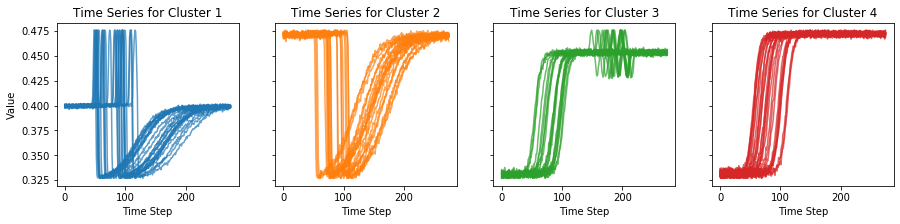

In [471]:
n_clusters = 4
fig, axes = plt.subplots(1, n_clusters, figsize = (15,3), sharey = True)

for i in range(n_clusters):  
    cluster_samples = X_log[Y_train == i+1]
    
    for sample in cluster_samples:
        axes[i].plot(sample, color=f'C{i}', alpha=0.7)  # Plot samples with the same cluster color
    
    # Add title and labels for each cluster
    axes[i].set_title(f'Time Series for Cluster {i+1}')
    axes[i].set_xlabel('Time Step')
axes[0].set_ylabel('Value')
plt.show()

First, I visualized the dataset labeled with 3 clusters. I suspected that the 3rd cluster might actually consist of two distinct groups rather than one.

To verify this, I then visualized the dataset with 4 clusters, and my suspicion appeared to be correct—the previously assigned 3rd cluster seemed to naturally split into two separate clusters.

# kMeans clustering

To determine the optimal number of clusters for K-means, I applied the Elbow Method. This technique involves fitting the K-means model with different values of k and plotting the inertia (sum of squared distances to the cluster centroids) against the number of clusters.

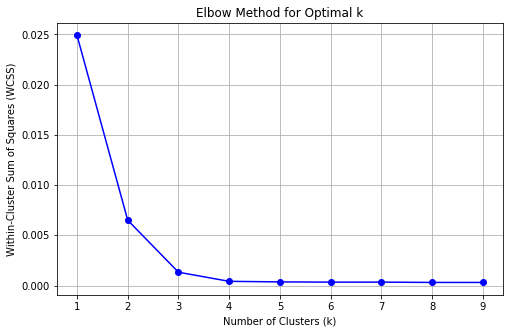

In [472]:
from tslearn.clustering import TimeSeriesKMeans

k_values = range(1, 10)  
sum_of_squares = []  

for k in k_values:
    kmeans = TimeSeriesKMeans(n_clusters = k, 
                              random_state = 42,  
                              n_init = 10,
                              metric = "dtw",
                              max_iter = 20)
    kmeans.fit(X_log)
    sum_of_squares.append(kmeans.inertia_)  

plt.figure(figsize=(8, 5))
plt.plot(k_values, sum_of_squares, marker = 'o', linestyle = '-', color = 'b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [473]:
from kneed import KneeLocator

kneedle = KneeLocator(k_values, sum_of_squares, curve="convex", direction="decreasing")
best_k = kneedle.elbow

print(f"The optimal number of clusters is: {best_k}")

The optimal number of clusters is: 3


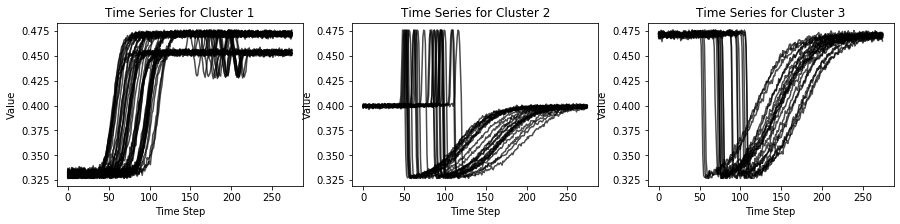

In [474]:
data = X_log
n_clusters = best_k

km = TimeSeriesKMeans(n_clusters=n_clusters,
                      random_state=42,
                      n_init=10,
                      metric="dtw",
                      max_iter=20)
labels = km.fit_predict(data)

fig, axes = plt.subplots(1, 3, figsize = (15,3))

for i in range(n_clusters):  
    cluster_samples = data[labels == i] 

    # Plot each sample in the cluster
    for sample in cluster_samples:
        axes[i].plot(sample.ravel(), "k-", alpha=0.7) 
    # Add title and labels for each cluster
    axes[i].set_title(f'Time Series for Cluster {i+1}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Value')
plt.show()

First, I applied K-Means clustering with 3 clusters, as suggested by the Elbow Method. However, I now want to perform hierarchical clustering manually by refining each cluster further.

To achieve this, I take each initial cluster and apply the Elbow Method again to determine the optimal number of subclusters. Then, I run K-Means on each cluster separately to identify potential substructures within them.

The optimal number for Main Cluster 1 is: 2
No clear elbow found for Main Cluster 2. Setting default k=1.
The optimal number for Main Cluster 2 is: 1
The optimal number for Main Cluster 3 is: 2


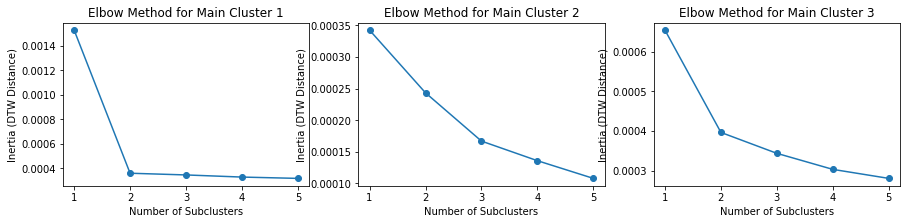

In [475]:
fig, axes = plt.subplots(1, 3, figsize = (15,3))

for cluster_id in range(3):
    X_subcluster = data[labels == cluster_id]  # Get data for this main cluster


    inertia = []
    K_range = range(1, 6)

    for k in K_range:
        sub_kmeans = TimeSeriesKMeans(n_clusters=k,
                      random_state=42,
                      n_init=10,
                      metric="dtw",
                      max_iter=20)
        sub_kmeans.fit(X_subcluster)
        inertia.append(sub_kmeans.inertia_)

    axes[cluster_id].plot(K_range, inertia, marker='o', linestyle='-')
    axes[cluster_id].set_xlabel('Number of Subclusters')
    axes[cluster_id].set_ylabel('Inertia (DTW Distance)')
    axes[cluster_id].set_title(f'Elbow Method for Main Cluster {cluster_id+1}')
    #Choose the best k
    kneedle = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
    best_k = kneedle.elbow
    
    if best_k is None:
        print(f"No clear elbow found for Main Cluster {cluster_id+1}. Setting default k=1.")
        best_k = 1 
    print(f"The optimal number for Main Cluster {cluster_id+1} is: {best_k}") 
    
plt.show()

For the second cluster, the Elbow Method suggested 1 cluster, so no further refinement was needed. However, the 1st and 3rd clusters required additional refinement, as they both showed potential for subclusters.

In [476]:
def perform_kmeans_and_plot(data, labels, cluster_index, n_clusters=2, random_state=42):
    X_subcluster = data[labels == cluster_index]         
    y_subcluster = Y_train[labels == cluster_index]

    final_sub_kmeans = TimeSeriesKMeans(n_clusters=n_clusters,
                                        random_state=random_state,
                                        n_init=10,
                                        metric="dtw",
                                        max_iter=20)
    sub_labels = final_sub_kmeans.fit_predict(X_subcluster)
    fig, axes = plt.subplots(1, 2, figsize = (15,3))


    for i in range(n_clusters):  
        cluster_samples = X_subcluster[sub_labels == i]  # Plot each sample in the cluster
        for sample in cluster_samples:
            axes[i].plot(sample.ravel(), "k-", alpha=0.7)  # Plot samples with the same cluster color
        # Add title and labels for each cluster
        axes[i].set_title(f'Time Series for Cluster {cluster_index + 1} - Subcluster {i + 1}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Value')
    plt.show()

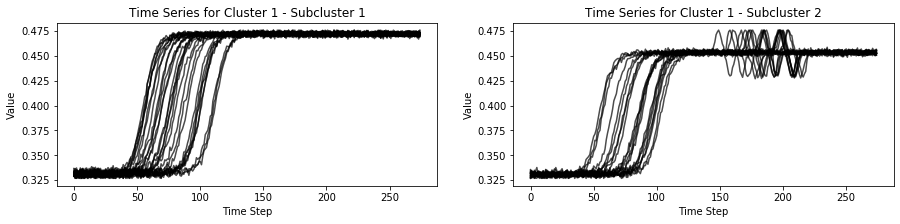

In [477]:
perform_kmeans_and_plot(data, labels, 0)

For the first cluster, which I had initial suspicions about, the Elbow Method suggested 2 clusters. After applying K-Means with 2 clusters, the results were much more accurate, and the clusters aligned perfectly.

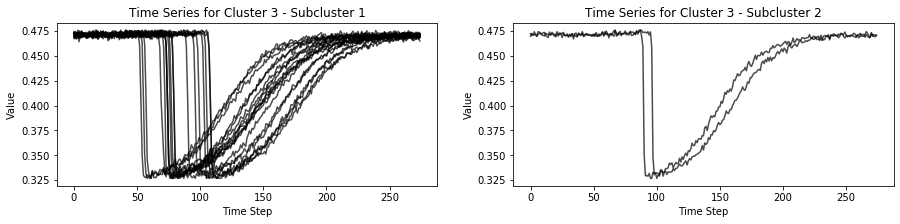

In [478]:
perform_kmeans_and_plot(data, labels, 2)

For the 3rd cluster, when I performed subclustering, I noticed that all samples were assigned to the 1st subcluster, with only two sample in the 2nd subcluster. Since this results in an ineffective split, I will ignore the subclustering process for this cluster and keep all the data points within a single cluster.

Now, I’ve decided to apply KMeans directly with 4 clusters and observe the results. 

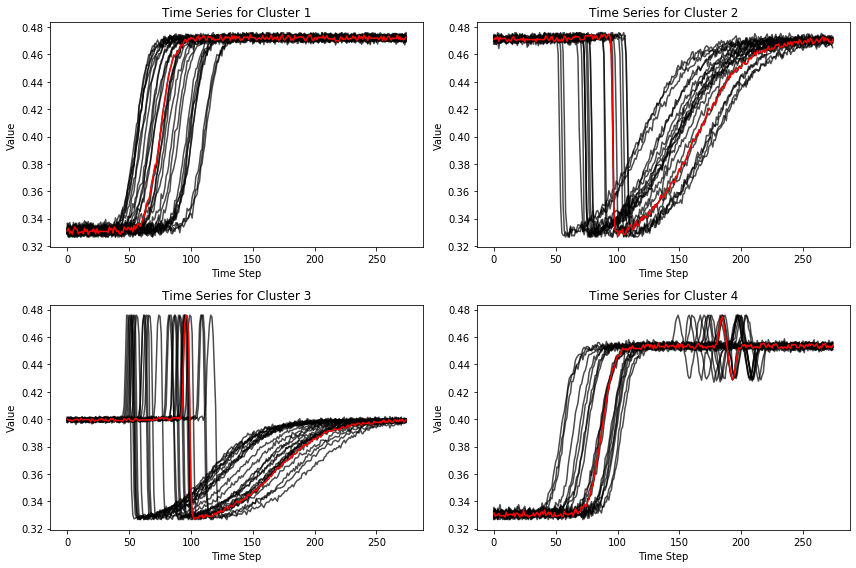

In [479]:
data = X_log
n_clusters = 4

km = TimeSeriesKMeans(n_clusters=n_clusters,
                      random_state=42, 
                      n_init=10,
                      metric="dtw",
                      max_iter=20)
labels = km.fit_predict(data)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()


for i in range(n_clusters):  

    cluster_samples = data[labels == i]  # Get samples in the current cluster

    # Plot each sample in the cluster
    for sample in cluster_samples:
        axes[i].plot(sample.ravel(), "k-", alpha=0.7)  # Plot samples with the same cluster color
    
    axes[i].plot(km.cluster_centers_[i].ravel(), "r-", label="Cluster Center")  # Plot the cluster center
    axes[i].set_title(f'Time Series for Cluster {i+1}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Value')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

This time, the clustering worked perfectly and produced more accurate results.

# Agglomerative Clustering

The dendrogram is used to analyze the hierarchical structure of the time series. Visually, the best split appears to be four clusters, as indicated by the horizontal cut.

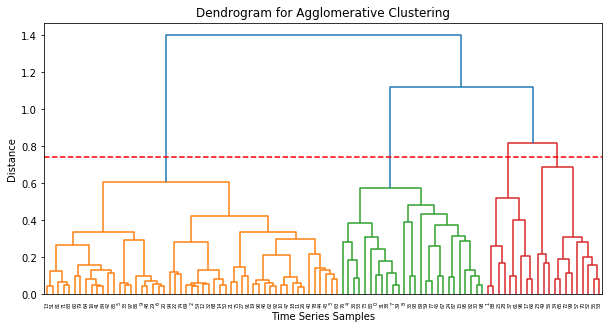

In [480]:
data_agg = X_log.reshape(X_log.shape[0], -1)  # Flatten for clustering

#Compute the linkage matrix
linkage_matrix = linkage(data_agg, method="average")

#Plot the dendrogram to find the optimal clusters
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, truncate_mode="level", p=10) 
plt.axhline(y=0.74, color='r', linestyle='--')
plt.xlabel("Time Series Samples")
plt.ylabel("Distance")
plt.title("Dendrogram for Agglomerative Clustering")
plt.show()

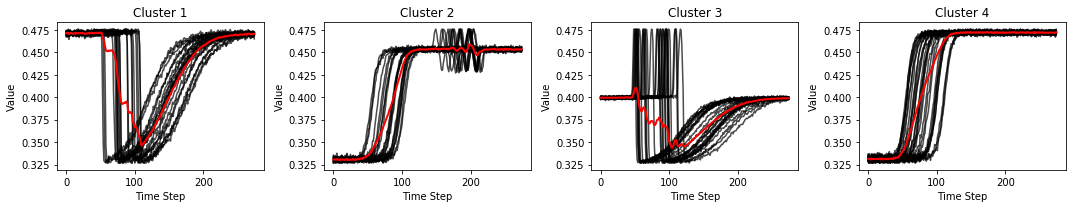

In [481]:
# Manually decide from the dendrogram
optimal_clusters = 4  

# compute DTW distance matrix
dtw_matrix = cdist_dtw(X_log)

#Apply Agglomerative Clustering with DTW distance
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, affinity="precomputed", linkage="average")
labels = agglo.fit_predict(dtw_matrix)

fig, axes = plt.subplots(1, optimal_clusters, figsize=(15, 3))
for i in range(optimal_clusters):
    cluster_samples = X_log[labels == i]
    
    for sample in cluster_samples:
        axes[i].plot(sample.ravel(), "k-", alpha=0.7)  # Individual time series
    
    axes[i].plot(np.mean(cluster_samples, axis=0).ravel(), "r-", linewidth=2)  # Cluster center
    axes[i].set_title(f"Cluster {i+1}")
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()


I used a dendrogram to determine the optimal number of clusters, and I see that a split at four clusters works well. With DTW, the clustering captures the patterns accurately.

# Conclusion

I initially used K-Means with DTW, which suggested three clusters based on the elbow method. However, after visualization, I noticed that one cluster was misclassified, so I applied a second round of K-Means to refine the grouping. This additional step improved the clustering but required manual intervention.

On the other hand, Agglomerative Clustering with DTW and a dendrogram naturally suggested four clusters, which aligned well with the structure of the data. The hierarchical approach allowed me to visually confirm the split and did not require further refinement.

Overall, Agglomerative Clustering proved to be the better choice for this dataset, as it handled shifts in the time series more effectively and provided a more interpretable clustering process without the need for manual re-clustering.